1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 95ms/step


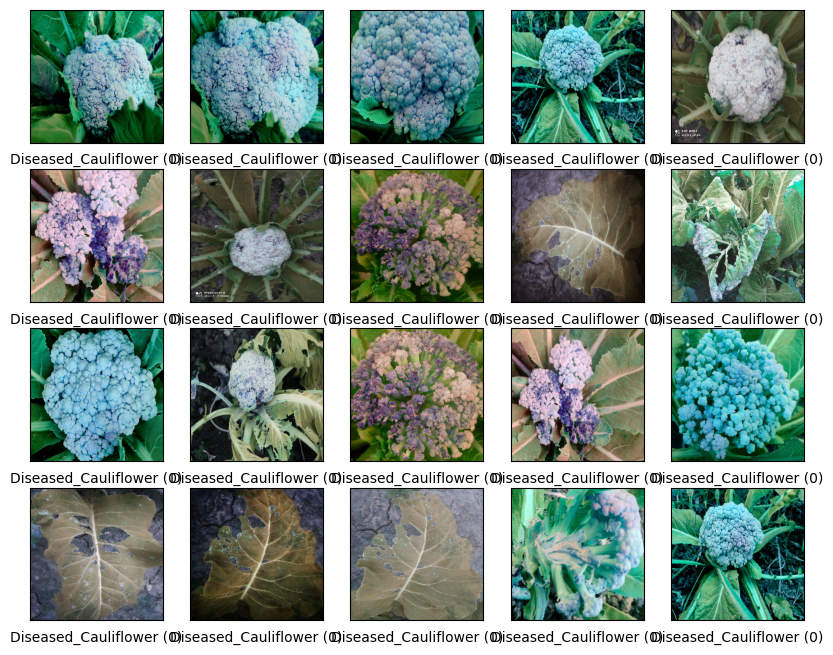

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 200)     5600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 200)    0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3225800)           0         
                                                                 
 dropout (Dropout)           (None, 3225800)           0         
                                                                 
 dense (Dense)               (None, 64)                206451264 
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                        

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.utils import plot_model

dir_path = 'data'
input_shape = (256, 256)

# Load pre-trained ResNet50 model
pre_trained_model = tf.keras.applications.ResNet50(weights='imagenet')

# Define a function to preprocess the image and predict the class using the pre-trained model
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    preds = pre_trained_model.predict(x)
    return decode_predictions(preds, top=1)[0][0][1]

def get_data(dir_path):
    x, y = [], []
    category = {"disease": 0, "no_disease": 1}
    folders = os.listdir(dir_path)
    
    for folder in folders:
        folder_path = os.path.join(dir_path, folder)
        files = os.listdir(folder_path)
        
        for file in files:
            file_path = os.path.join(folder_path, file)
            # Add a pre-screener to catch images that are not cauliflower and do not belong to the same category
            try:
                prediction = predict_image(file_path)
            except:
                print(f"Error reading image {file_path}. Skipping this image.")
                continue
            
            if prediction != "cauliflower" or category[folder] != 0:
                continue
            img = cv2.imread(file_path)
            x.append(cv2.resize(img, input_shape))
            y.append(category[folder])

    x = np.array(x)
    y = np.array(y)
    x, y = shuffle(x, y)
    return x, y


x_data, y_data = get_data(dir_path)

labels = {0: "Diseased_Cauliflower", 1: "Healthy_Cauliflower"}

# Visualization
plt.figure(figsize=(10, 10))

for i in range(20):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_data[i])
    label = y_data[i]
    plt.xlabel(f"{labels[label]} ({label})")

plt.show()

# Split the data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1, stratify=y_data)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.8, random_state=1, stratify=y_test)

# Normalize the data
x_train = x_train / 255
x_test = x_test / 255
x_val = x_val / 255

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)


# Create the CNN model
input_dim = (256, 256, 3)
cauliflower_model = Sequential()

cauliflower_model.add(Conv2D(200, (3, 3), activation='relu', strides=(1, 1), input_shape=input_dim))
cauliflower_model.add(MaxPooling2D((2, 2)))


cauliflower_model.add(Flatten())
cauliflower_model.add(Dropout(0.5))


cauliflower_model.add(Dense(64, activation='relu'))

cauliflower_model.add(Dense(2, activation='softmax'))

# Compile the model
cauliflower_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Model summary
cauliflower_model.summary()


# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint("Cauliflower_best_model.h5", save_best_only=True, save_weights_only=False)

# Train the model
cauliflower_model.fit(x_train, y_train, epochs=4, validation_data=(x_val, y_val), callbacks=[checkpoint_callback])

scores = cauliflower_model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

cauliflower_model.save_weights('cauliflower_model_weights.h5')
json_string = cauliflower_model.to_json()
with open("model_architecture.json",'w') as f:
    f.write(json_string)


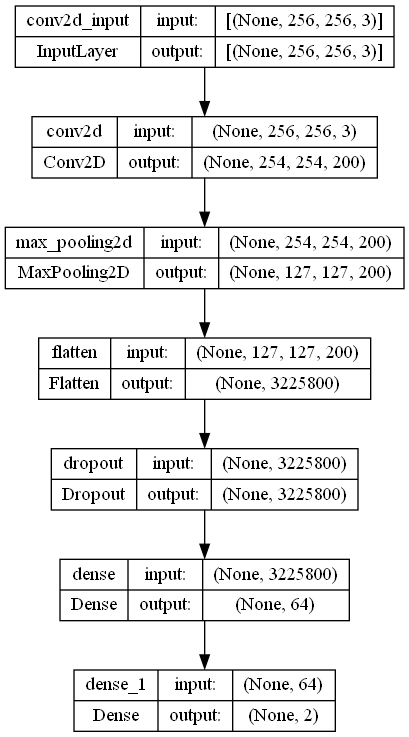

In [2]:
plot_model(cauliflower_model, to_file='model.png', show_shapes=True, show_layer_names=True)